In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd drive/My Drive/Colab Notebooks/SVM_Fresh/Model/VGG16

In [ ]:
import torch
import torch.nn as nn
import torchvision
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, random_split

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

origin_dataset = torchvision.datasets.CIFAR10(root='/content/drive/My Drive/Colab Notebooks/SVM_Fresh/CIFAR10', train=True,download=True, transform=transform)

train_size = int(0.8*len(origin_dataset))
val_size = len(origin_dataset) - train_size

train_set, val_set = random_split(origin_dataset, [train_size, val_size])
print(len(train_set))
print(len(val_set))

Files already downloaded and verified
40000
10000


In [ ]:
batch_size = 100

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=0)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False, num_workers=0)

In [ ]:
test_set = torchvision.datasets.CIFAR10(root='/content/drive/My Drive/Colab Notebooks/SVM_Fresh/CIFAR10', train=False, download=True, transform=transform)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=0)
classes = ('plane', 'car', 'bird', 'cat', 'deer','dog', 'frog','horse','ship','truck')

Files already downloaded and verified


In [ ]:
class conv_x2(nn.Module):
  def __init__(self, in_channels, out_channels):
    super().__init__()
    self.in_channels = in_channels
    self.layer = nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2)
    )

  def forward(self, x):
    x = self.layer(x)
    return x

class conv_x3(nn.Module):
  def __init__(self, in_channels, out_channels):
    super().__init__()
    self.in_channels = in_channels
    self.layer = nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
        nn.MaxPool2d(kernel_size=2, stride=2)
    )

  def forward(self, x):
    x = self.layer(x)
    return x

class VGG16(nn.Module):
  def __init__(self, block2, block3, base_dim=64,num_classes=10):
    super().__init__()
    self.base_dim = base_dim
    self.conv1 = self._make_layer(block2, 3, base_dim)
    self.conv2 = self._make_layer(block2, base_dim, base_dim*2)
    self.conv3 = self._make_layer(block3, base_dim*2, base_dim*4)
    self.conv4 = self._make_layer(block3, base_dim*4, base_dim*8)
    self.conv5 = self._make_layer(block3, base_dim*8, base_dim*8)

    self.fc_layer = nn.Sequential(
      # CIFAR10은 크기가 32x32이므로
      nn.Linear(8*base_dim*1*1, 4096),
      # IMAGENET이면 224x224이므로
      # nn.Linear(8*base_dim*7*7, 4096),
      nn.ReLU(True),
      nn.Dropout(),
      nn.Linear(4096, 1000),
      nn.ReLU(True),
      nn.Dropout(),
      nn.Linear(1000, num_classes),
    )

  def _make_layer(self, block, in_channels, out_channels, num=2):
    layers = []
    layers.append(block(in_channels, out_channels))
    return nn.Sequential(*layers)

  def forward(self, x):
    x = self.conv1(x)
    x = self.conv2(x)
    x = self.conv3(x)
    x = self.conv4(x)
    x = self.conv5(x)
    x = x.view(x.size(0), -1)
    x = self.fc_layer(x)

    return x

  def _initialize_weights(self):
    for m in self.modules():
      if isinstance(m, nn.Conv2d):
        nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
        if m.bias is not None:
          nn.init.constant_(m.bias, 0)
      elif isinstance(m, nn.BatchNorm2d):
        nn.init.constant_(m.weight, 1)
        nn.init.constant_(m.bias, 0)
      elif isinstance(m, nn.Linear):
        nn.init.normal_(m.weight, 0, 0.01)
        nn.init.constant_(m.bias, 0)

def vgg16():
  return VGG16(conv_x2, conv_x3)

In [ ]:
# device
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Reproducibility
torch.manual_seed(123)
if device == 'cuda':
    torch.cuda.manual_seed_all(123)

model = vgg16().to(device)

In [ ]:
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0002)

In [ ]:
EPOCH = 10
loss_arr = []
acc_list = []
for i in range(EPOCH):
  prob = 0
  total = 0
  for j,[image,label] in enumerate(train_loader):
    x = image.to(device)
    y_= label.to(device)

    optimizer.zero_grad()
    output = model.forward(x)

    _, pred = torch.max(output, 1)
    prob += (pred == y_).sum().float()
    total += label.size(0)

    loss = loss_func(output,y_)
    loss.backward()
    optimizer.step()
  if i % 2 == 0:
    print(loss)
    acc_list.append((prob/total).cpu().detach().numpy())
    loss_arr.append(loss.cpu().detach().numpy())

tensor(1.8143, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.3295, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.8113, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.7622, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.4436, device='cuda:0', grad_fn=<NllLossBackward0>)


In [ ]:
# 맞은 개수, 전체 개수를 저장할 변수를 지정합니다.
correct = 0
total = 0

model.eval()

with torch.no_grad():
    for image,label in test_loader:

        x = image.to(device)
        y= label.to(device)

        output = model.forward(x)
        _,output_index = torch.max(output,1)

        total += label.size(0)
        correct += (output_index == y).sum().float()

    print("Accuracy of Test Data: {}%".format(100*correct/total))

Accuracy of Test Data: 76.18999481201172%


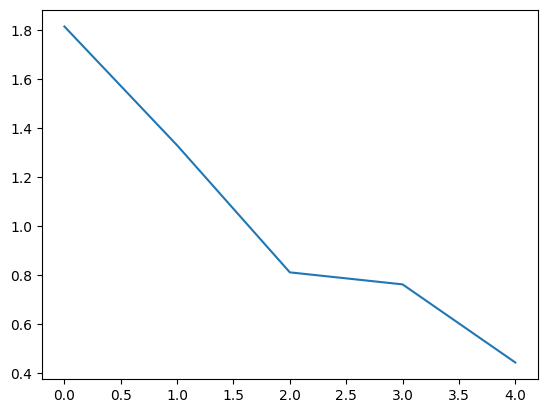

In [ ]:
import matplotlib.pyplot as plt

plt.plot(range(len(loss_arr)), loss_arr)
plt.show()

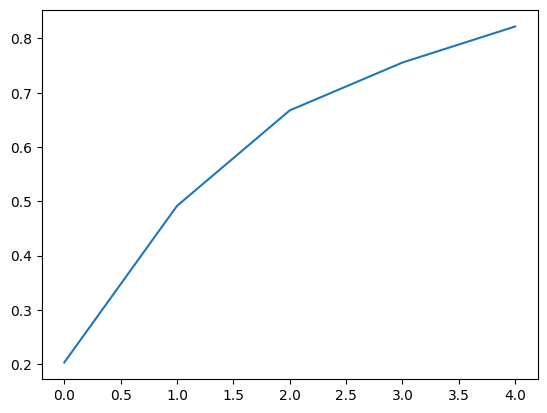

In [ ]:
plt.plot(range(len(acc_list)), acc_list)
plt.show()